# Pipeline analysis for unsupervised data
Let's start simple by analyzing the data from a single individual, considering: total distance, look-around, sniffing, inner-zone time, wall-climbing, and huddle. We start by importing the necessary packages and directories.

In [1]:
import os
import pandas as pd
import pickle
import deepof.data
import deepof.visuals
import visuals_customized
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Open an existing DeepOF project
directory_output = '//folder/becell/Lab Projects/ERCstG_HighMemory/Data/Marc/1) SOC/2024-01a02 cFos/'
my_deepof_project = deepof.data.load_project(directory_output + "deepof_tutorial_project")

In [3]:
# Open an existing supervised analysis
with open(directory_output + 'supervised_annotation.pkl', 'rb') as file:
    supervised_annotation = pickle.load(file)

In [4]:
# Load conditions
my_deepof_project.load_exp_conditions(directory_output + 'conditions.csv')

In [5]:
# Define colors
white = '#FFFFFF'
grey_soft = '#D3D3D3'
grey_stark = '#636466'
blue = '#194680'
red = '#801946'

## Plot silhouettes and UMAP

In [6]:
# Import trained models
with open(directory_output + 'new_silhouette_score_dict.pkl', 'rb') as file:
    new_silhouette_score_dict = pickle.load(file)

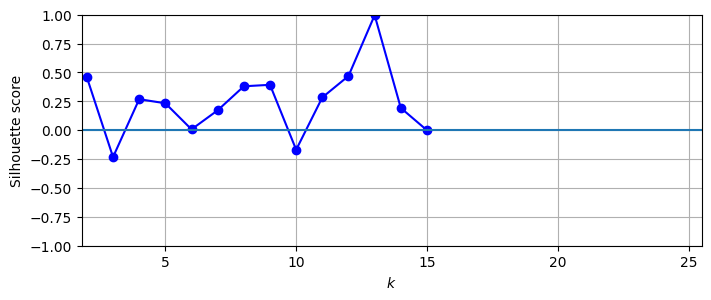

In [7]:
# Plot global silhouettes
visuals_customized.plot_silhouette_scores(new_silhouette_score_dict)

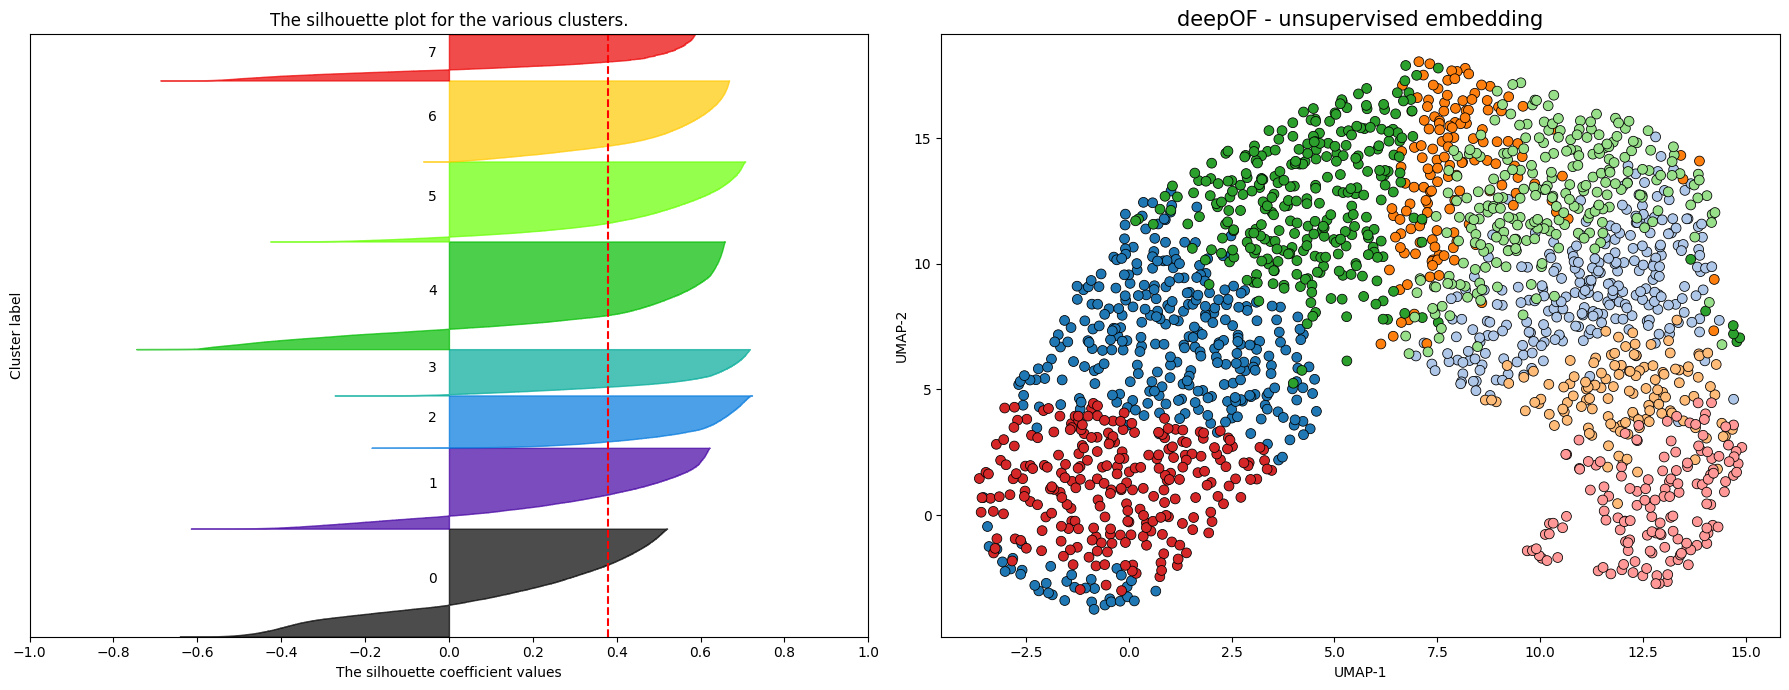

In [8]:
# Plot cluster silhouettes and UMAP
visuals_customized.silhouette_diagrams(new_silhouette_score_dict, my_deepof_project, [8])

In [7]:
num_clusters = 8
embeddings = new_silhouette_score_dict[num_clusters][3]
soft_counts = new_silhouette_score_dict[num_clusters][4]
breaks = new_silhouette_score_dict[num_clusters][5]

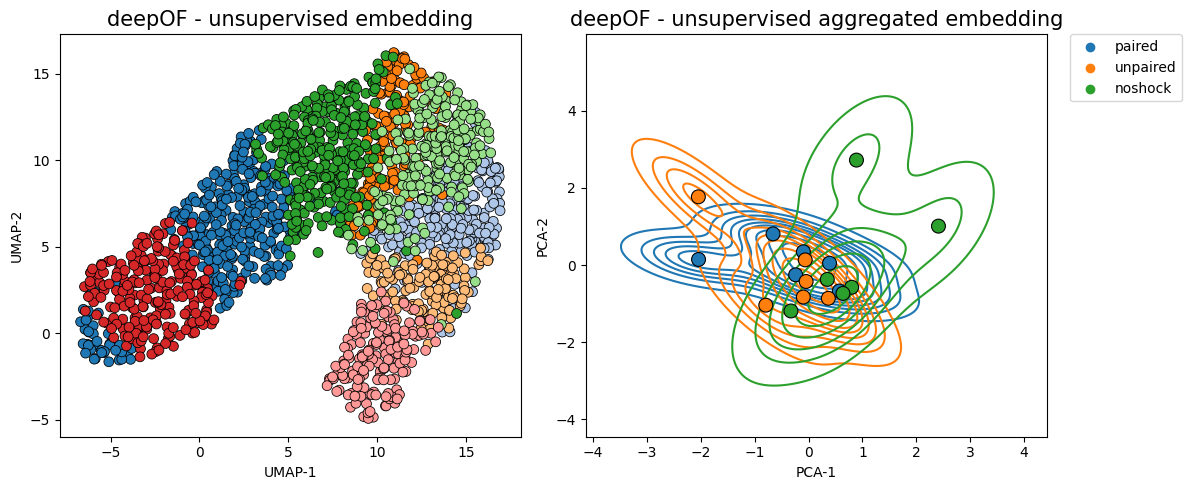

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    aggregate_experiments=False,
    samples=100,
    ax=ax1,
    save=False, # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    aggregate_experiments="time on cluster", # Can also be set to 'mean' and 'median'
    exp_condition="protocol",
    show_aggregated_density=True,
    ax=ax2,
    save=False, # Set to True, or give a custom name, to save the plot,
)
ax2.legend(
    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0
)

plt.tight_layout()
plt.show()

## Global separation dynamics
Next, let’s quantify the distance between our experimental distributions. To measure how far the behavior of stressed animals is from that of controls, we’ll use the **Wasserstein distance** between the distributions. Moreover, we’ll see how that distance evolves over time.

In [77]:
import numpy as np
import post_hoc_customized
from collections import Counter, defaultdict
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KernelDensity
import ot
import math
from itertools import combinations

num_clusters = 8
embeddings = new_silhouette_score_dict[num_clusters][3]
soft_counts = new_silhouette_score_dict[num_clusters][4]
breaks = new_silhouette_score_dict[num_clusters][5]

coordinates=my_deepof_project
embedding=embeddings
soft_counts=soft_counts
breaks=breaks
exp_condition="protocol"
embedding_aggregation_method='time_on_cluster'
distance_metric="wasserstein"
n_jobs=1
start_seconds_bin = 120
end_seconds_bin = 360

exp_conditions = { key: val[exp_condition].values[0] for key, val in coordinates.get_exp_conditions.items()}
start_bin = start_seconds_bin * coordinates._frame_rate
end_bin = end_seconds_bin * coordinates._frame_rate
step_bin = coordinates._frame_rate
scan_mode = "growing_window"
precomputed_bins = None
agg = embedding_aggregation_method
metric=distance_metric

bin_range = range(start_bin, end_bin, step_bin)

cur_embedding, cur_soft_counts, cur_breaks, _ = post_hoc_customized.select_time_bin(
                embedding, soft_counts, breaks, bin_size=50, bin_index=0
            )

aggregated_embeddings, _, _ = post_hoc_customized.get_time_on_cluster(                  # Modified by mcanela
            cur_soft_counts, cur_breaks, reduce_dim=True
        )
aggregated_embeddings["exp_condition"] = aggregated_embeddings.index.map(
            exp_conditions
        )
arrays_to_compare = [
            aggregated_embeddings.loc[aggregated_embeddings.exp_condition == cond]
            .drop("exp_condition", axis=1)
            .values
            for cond in set(exp_conditions.values())
        ]
arrays_to_compare = [
                KernelDensity().fit(arr).sample(100, random_state=0)
                for arr in arrays_to_compare
            ]


distance_list = []
for combination in list(combinations(range(1, len(arrays_to_compare)+1), 2)):
    new_list = [arrays_to_compare[combination[0]-1], arrays_to_compare[combination[1]-1]]
    current_distance = ot.sliced_wasserstein_distance(
                    *new_list, n_projections=10000
                )
    distance_list.append(current_distance)
    
current_distance = np.mean(distance_list)           
print(current_distance)




#post_hoc_customized.separation_between_conditions






1.4570088202228797


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (100,10000) (1,2) 

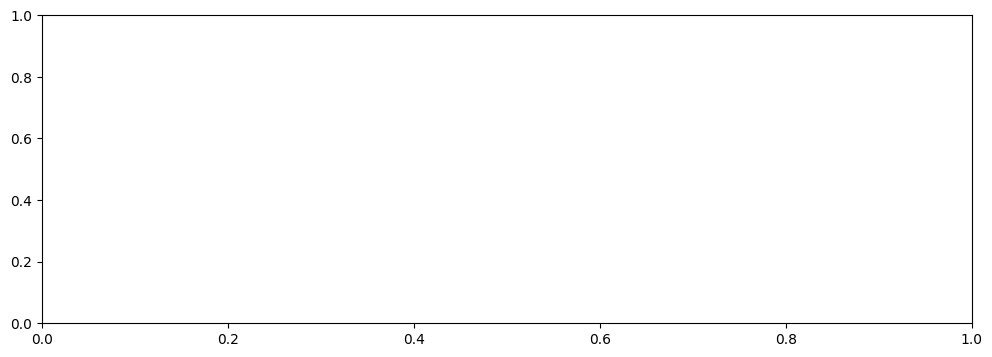

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

visuals_customized.plot_distance_between_conditions(
    coordinates=my_deepof_project,
    embedding=embeddings,
    soft_counts=soft_counts,
    breaks=breaks,
    exp_condition="protocol",
    start_seconds_bin = 120,
    end_seconds_bin = 360,
    embedding_aggregation_method='time_on_cluster',
    distance_metric="wasserstein",
    n_jobs=1,
)

plt.show()

## Plot PCA between conditions

In [ ]:
# Define the coordinates for the labels of each condition
coords_dict = {
    'hc_ind': ['name1', [4,5]],
    'hc_ee': ['name2', [4,5]],
    }

In [ ]:
# Define the colors for each condition
color_dict = {
    'hc_ind': sns.color_palette("Set1")[0],,
    'hc_ee': sns.color_palette("Set1")[1],
    }

In [ ]:
ax, embedding_dataset, rotated_loading_scores, dataframe_for_titles = visuals_customized.plot_embeddings(
    my_deepof_project,
    supervised_annotations=supervised_annotation,
    bin_size=120,
    bin_index=0,
    my_title = 'PCA first time bin',
    my_color_dict = color_dict,
    my_coords_dict = coords_dict
)

### Analyze individual PC and rotated_loading_scores

In [ ]:
# Perform statistics
import pingouin as pg
pg.normality(embedding_dataset, 'PCA-2', 'experimental condition')
pg.homoscedasticity(embedding_dataset, 'PCA-2', 'experimental condition')

x = embedding_dataset[embedding_dataset['experimental condition'] == 'hc_ee']['PCA-2']
y = embedding_dataset[embedding_dataset['experimental condition'] == 'hc_ind']['PCA-2']
pg.ttest(x, y).round(3)

# pg.anova(embedding_dataset, 'PCA-1', 'experimental condition')
# pg.pairwise_tukey(embedding_dataset, 'PCA-1', 'experimental condition')

In [ ]:
# Save your statistics in a dictionary
stats_dict = {
    '*': ['hc_ee', 'hc_ind']
    }

In [ ]:
# Plot the PC components
visuals_customized.boxplot(embedding_dataset, color_dict, 'PCA-1', stats_dict)

In [ ]:
# Plot the rotated loading scores of PC components
visuals_customized.lollipop(dataframe_for_titles, rotated_loading_scores, 'PCA-1')

## Plot PCA between time points

In [ ]:
# Define the coordinates for the labels of each condition
coords_dict = {
#    'bin0': ['name1', [4,5]],
#    'bin1': ['name2', [4,5]],
    'bin2': ['Before tone', [-4,5]],
    'bin3': ['During tone', [4,3.5]],
    }

In [ ]:
# Define the colors for each condition
color_dict = {
#    'bin0': sns.color_palette("Set1")[0],
#    'bin1': sns.color_palette("Set1")[1],
    'bin2': grey_stark,
    'bin3': blue
    }

In [ ]:
ax, embedding_dataset, rotated_loading_scores, dataframe_for_titles, concat_hue = visuals_customized.plot_embeddings_timelapse(
    my_deepof_project,
    supervised_annotations=supervised_annotation,
    bin_size=60,
    bin_index_list=[2,3],
    my_title = 'No-shock',
    my_color_dict = color_dict,
    my_coords_dict = coords_dict,
    specific_condition = 'noshock',
)

### Analyze individual PC, rotated_loading_scores (across time) 

In [ ]:
# Perform statistics
import pingouin as pg
pg.normality(embedding_dataset, 'PCA-1', 'experimental condition')

In [ ]:
pg.homoscedasticity(embedding_dataset, 'PCA-1', 'experimental condition')

In [ ]:
x = embedding_dataset[embedding_dataset['experimental condition'] == 'bin2']['PCA-1']
y = embedding_dataset[embedding_dataset['experimental condition'] == 'bin3']['PCA-1']
pg.ttest(x, y).round(3)

In [ ]:
pg.anova(embedding_dataset, 'PCA-1', 'experimental condition')
pg.pairwise_tukey(embedding_dataset, 'PCA-1', 'experimental condition')

In [ ]:
# Save your statistics in a dictionary
stats_dict = {
    #'**': ['bin0', 'bin1'],
    #'***': ['bin0', 'bin2'],
    'ns': ['bin2', 'bin3'],
    }

In [ ]:
# Plot the PC components
visuals_customized.boxplot(embedding_dataset, color_dict, 'PCA-1', stats_dict)

In [ ]:
# Plot the rotated loading scores of PC components
visuals_customized.lollipop(dataframe_for_titles, rotated_loading_scores, 'PCA-1')

In [ ]:
# Plot an individual behavior over bins
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'huddle')

In [ ]:
# Plot some individual behaviors over bins
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'huddle', ax=ax1)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'speed', ax=ax2)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'sniffing', ax=ax3)

# ax1.set_title("supervised embeddings of full videos")
# ax2.set_title("supervised embeddings of first two minutes")

plt.tight_layout()
plt.show()